In [2]:
import numpy as np
from astropy.table import Table

from lsst.daf.persistence import Butler
import lsst.geom as geom
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
from scipy.stats import poisson
from lsst.afw.math import Warper

import lsst.afw.geom as afwGeom



import lsst.geom as geom
import lsst.afw.image as afwImage

In [3]:
# Setup data id
tract, patch, filt = 4639, '0,0', 'r'
visit, detector = 181868, 57
calexp_id = {'visit': visit, 'detector': detector, 'filter': filt}
deepCoadd_id = {'tract': tract, 'patch': patch, 'filter': filt}

In [4]:
calexp_repo = '/global/cscratch1/sd/desc/DC2/data/Run2.1i/rerun/calexp-v1'
calexp_butler = Butler(calexp_repo)
calexp_exposure = calexp_butler.get('calexp',  calexp_id)

In [5]:
template_repo = '/global/cscratch1/sd/desc/DC2/data/Run2.1i/rerun/coadd-dr1b-v1-grizy'
template_butler = Butler(template_repo)
template_exposure = template_butler.get('deepCoadd',  deepCoadd_id)


## 1. make injection

In [13]:
def inject_stars(exposure, photoCalib, x, y, magVar, poisson=False, seed=None):
    exposure.mask.addMaskPlane("FAKE")
    bitmask = exposure.mask.getPlaneBitMask("FAKE")
    xy = geom.Point2D(x, y)
    psf = exposure.getPsf()
    starIm = psf.computeImage(xy)
    calibFluxRadius = 12
    correctedFlux = psf.computeApertureFlux(calibFluxRadius, xy)
    starIm /= correctedFlux
    flux = photoCalib.magnitudeToInstFlux(magVar, xy)
    starIm *= flux
    star_shape = starIm.array.shape
    star_array = starIm.getArray()
    star_array[star_array < 1e-19] = 0.

    if poisson:
        # The array of starIm will be changed inplace, we make a copy here to calculate the variance plane.
        star_array_copy = starIm.array.copy()
        star_array_copy = np.float32(star_array_copy)
        
        for i in range(star_shape[0]):
            for j in range(star_shape[1]):
                np.random.seed(seed)
                star_array[i][j] = np.random.poisson(star_array[i][j] * 0.7) / 0.7

    fakeImage = starIm.convertF()
    imageBBox = exposure.getBBox()
    imageMI = exposure.maskedImage

    interpFakeImage = fakeImage
    interpFakeImBBox = fakeImage.getBBox()
    interpFakeImBBox.clip(imageBBox)
    imageMIView = imageMI.Factory(imageMI, interpFakeImBBox)

    if interpFakeImBBox.getArea() > 0:
        clippedFakeImage = interpFakeImage.Factory(interpFakeImage, interpFakeImBBox)
        clippedFakeImageMI = afwImage.MaskedImageF(clippedFakeImage)
        clippedFakeImageMI.mask.set(bitmask)
        if poisson:
            clippedFakeImageMI.variance.array = star_array_copy / 0.7
        imageMIView += clippedFakeImageMI
        
def save_fakes(calexp_repo, calexp_id, magVar, src_table, poisson=False):
    
    calexp_butler = Butler(calexp_repo)
    calexp_photoCalib = calexp_butler.get('calexp_photoCalib',  calexp_id)
    calexp_exposure = calexp_butler.get('calexp', dataId=calexp_id)
    for row in src_table:
        x, y = row['base_NaiveCentroid_x'], row['base_NaiveCentroid_y']
        seed = int('{}{}{}'.format(18, int(magVar * 10), int(x) + int(y)))
        inject_stars(calexp_exposure, calexp_photoCalib, x, y, magVar, poisson=False, seed=seed)
    calexp_butler.put(calexp_exposure, 'calexp', dataId=calexp_id)

We start with fake injection.

1. Create an empty repo for injection. I have already create one. So just copy.

`cp -r /global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/empty_calexp_repo ./test_repo`

2. Inject fakes onto a calexp exposure, and put that into the test_repo

In [14]:
# This table stores the injection coordinates.
injection_table = Table.read('/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/star_table/check21_offset_25.txt',
                             format='ascii')
mag = 17.5
repo = './test_repo'
save_fakes(repo, calexp_id, mag, injection_table, poisson=False)

3. run image subtraction

```
imageDifferenceDriver.py /global/u1/s/shl159/fake_injection/test_repo \
    --output /global/u1/s/shl159/fake_injection/test_diff \
    --id visit=181868 detector=57  -C diffimConfig_al.py \
    --clobber-config --clobber-versions --cores 4
```

## 2. Detection

In [26]:
def filter_src(src_table):
    # This function filters out sources with flags.
    FLAG_LIST = ['base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_interpolated',
                'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_cr', 'base_PixelFlags_flag_bad',
                'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_interpolatedCenter', 'base_PixelFlags_flag_saturatedCenter',
                'base_PixelFlags_flag_crCenter', 'base_PixelFlags_flag_suspectCenter']

    row_num = []
    for num, src in enumerate(src_table):
        flag_count = 0
        for flag in FLAG_LIST:
            # Here is data type is np.bool_, not python's built-in bool
            if src[flag] is np.bool_(True):
                flag_count += 1
        if flag_count == 0:
            row_num.append(num)
    good_table = src_table[row_num]
    return good_table

def check_detecion(repo, data_id, table_type, check_table, half_side=4, filt_flag=False):
    # check table has the positions of injections.
    # filt_flag: apply the flag selection to dia source table
    detected_set = set()
    missed_set = set()
    dia_list = []
    butler = Butler(repo)
    source_table = butler.get(table_type, dataId=data_id)
    source_astropy = source_table.asAstropy()
    if filt_flag:
        good_table = filter_src(source_astropy)
    else:
        good_table = source_astropy.copy()
    
    for i, star in enumerate(check_table):
        qualified_list = []
        count = 0
        x = star['base_NaiveCentroid_x']
        y = star['base_NaiveCentroid_y']
        for src in good_table:
            src_x = src['base_NaiveCentroid_x']
            src_y = src['base_NaiveCentroid_y']
            if np.abs(x - src_x) < half_side and np.abs(y - src_y) < half_side:
                detected_set.add(i)
                qualified_list.append((src_x, src_y))
                count += 1
        if count == 0:
            missed_set.add(i)
        dia_list.append(qualified_list)
    return detected_set, missed_set, dia_list

In [30]:
detected, missed, detection_coords = check_detecion('./test_diff', calexp_id, 'deepDiff_diaSrc',
                                                               injection_table, half_side=4, filt_flag=False)

In [31]:
print(f'efficiency: {len(detected) / (len(detected) + len(missed))}')

efficiency: 0.85


In [33]:
print(f'missed id: {missed}')

missed id: {8, 9, 17}


So we have three missing objects. If we increase our searching radius (half_side) to 20, we can detect all injections.

In [41]:
detected, missed, detection_coords = check_detecion('./test_diff', calexp_id, 'deepDiff_diaSrc',
                                                               injection_table, half_side=20, filt_flag=False)

In [42]:
print(f'efficiency: {len(detected) / (len(detected) + len(missed))}')

efficiency: 1.0


## Post stamps

We show the post stamps of the objects which are missed at `half_side = 4`.

In [43]:
def make_cutout(exposure, x, y, cutout_size=60):
    # Make a cutout exposure at (x, y).
    cutout_extent = geom.ExtentI(cutout_size, cutout_size)
    radec = geom.SpherePoint(exposure.getWcs().pixelToSky(x, y))
    cutout_image = exposure.getCutout(radec, cutout_extent)
    return cutout_image

def display_diff(diff_exposure, x, y, cutout_size=60, dia_list=None, scale=None, frame=None, title=None,
                save_name=None):
    cutout_extent = geom.ExtentI(cutout_size, cutout_size)
    radec = geom.SpherePoint(diff_exposure.getWcs().pixelToSky(x, y))
    cutout_image = diff_exposure.getCutout(radec, cutout_extent)
    
    xy = geom.PointI(x, y)
    display = afwDisplay.Display(frame=frame, backend='matplotlib')
    if scale:
        display.scale("linear", scale[0], scale[1])
    else:
        display.scale("linear", "zscale")
    display.mtv(cutout_image)
    display.show_colorbar()
    display.dot('o', xy.getX(), xy.getY(), ctype='red')
    
    for coord in dia_list:
        coord_x, coord_y = coord
        display.dot('o', coord_x, coord_y, ctype='green')
        
    
    plt.title(title)
    if save_name:
        plt.savefig(save_name, dpi=500)
        

In [67]:
test_butler = Butler('./test_diff')

In [38]:
diff_exposure = test_butler.get('deepDiff_differenceExp', calexp_id)

detected position: [(2855.0867608452004, 1672.384031334263)]


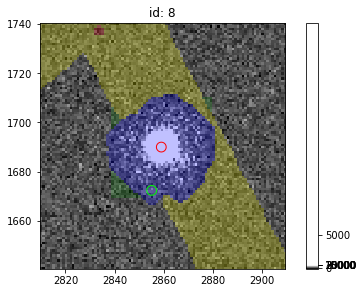

In [56]:
idx = 8
x, y = injection_table[idx]['base_NaiveCentroid_x'], injection_table[idx]['base_NaiveCentroid_y']
display_diff(diff_exposure, x, y, cutout_size=100, dia_list=detection_coords[idx], title=f'id: {idx}')
print(f'detected position: {detection_coords[idx]}')

detected position: [(1213.4810586370206, 1692.0753996662168)]


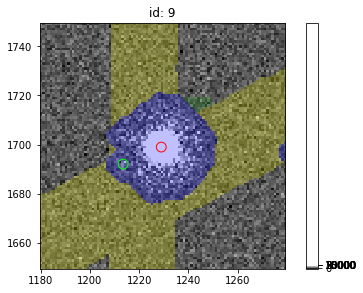

In [55]:
idx = 9
x, y = injection_table[idx]['base_NaiveCentroid_x'], injection_table[idx]['base_NaiveCentroid_y']
display_diff(diff_exposure, x, y, cutout_size=100, dia_list=detection_coords[idx], title=f'id: {idx}')
print(f'detected position: {detection_coords[idx]}')

detected position: [(2745.0739319882978, 2370.2788064536962)]


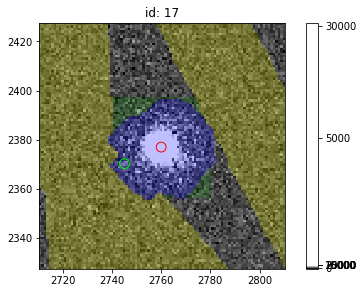

In [54]:
idx = 17
x, y = injection_table[idx]['base_NaiveCentroid_x'], injection_table[idx]['base_NaiveCentroid_y']
display_diff(diff_exposure, x, y, cutout_size=100, dia_list=detection_coords[idx], title=f'id: {idx}')
print(f'detected position: {detection_coords[idx]}')

So there is an offset between the injection position and the detection position.

## Another Situation (Binary injection).

Almost all of the missing objects at bright injection magnitude are recovered with an offset to the injection positions. But there is one situation, where I inject two stars very close to each other, and the detection algorithm only find one star.

In [59]:
injection_table = Table.read('/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/star_table/check22_offset_25.txt',
                             format='ascii')
mag = 17.5
repo = './test_repo_2'
save_fakes(repo, calexp_id, mag, injection_table, poisson=False)

In [65]:
detected, missed, detection_coords = check_detecion('./test_diff_2', calexp_id, 'deepDiff_diaSrc',
                                                               injection_table, half_side=50, filt_flag=False)

In [61]:
test_butler_2 = Butler('./test_diff_2')
diff_exposure_2 = test_butler_2.get('deepDiff_differenceExp', calexp_id)

detected position: [(2596.0040541824847, 1148.016773781796)]


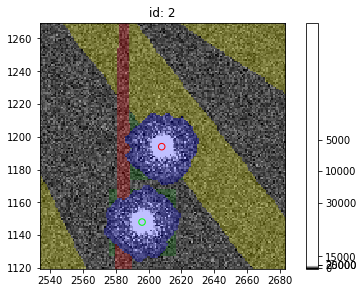

In [66]:
idx = 2
x, y = injection_table[idx]['base_NaiveCentroid_x'], injection_table[idx]['base_NaiveCentroid_y']
display_diff(diff_exposure_2, x, y, cutout_size=150, dia_list=detection_coords[idx], title=f'id: {idx}')
print(f'detected position: {detection_coords[idx]}')

## Summary

There are some missing objects at bright injection magnitude (<22). Most of them are recovered with an offset to the injection posiiton. One object is permanently missed when another source is injected next to it.

Offset objects are save at: 
- calexp_repo: `/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/test/test_repo`
- diff_repo: `/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/test/test_diff`

Binary Injection:
- calexp_repo: `/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/test/test_repo_2`
- diff_repo: `/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/test/test_diff_2`